# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)        
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)



<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import os
import numpy as np
from q3dfit.common.questfit_readcf import readcf

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [7]:
# book-keeping variables (unique to the user)
# Input files
volume = '../../../MIRISIM/MIRI-ETC-SIM/' # base directory
infile = volume+'miri_etc_cube.fits' # path + name of your input cube
cfinfile = '../test/test_questfit/miritest.cf'
qsotemplate = '../data/questfit_templates/miri_qsotemplate.npy'

# Output directories/files
outdir = volume+'outputs/' # path + name of directory for saving the output files
logfile = outdir+'miritest_fitlog.txt' # path to output logfile
path_to_npy_file = outdir # path for initproc.npy

In [8]:
volume = '/Users/drupke/Box Sync/q3d/simulations/MIRI-ETC-SIM/' # base directory
infile = volume+'miri_etc_cube.fits' # path + name of your input cube
outdir = '/Users/drupke/specfits/q3dfit/testing/mockETCcube/' # path + name of directory for saving the output files
logfile = outdir+'miritest_fitlog.txt' # path to output logfile
path_to_npy_file = outdir # path for initproc.npy



Some general information about your cube:

In [9]:
ncols = 16
nrows = 25
fitrange = [11.53050463,13.47485667] # in micron
if not os.path.isfile(infile): 
    print('Data cube not found.')
global_ice_model = 'ice_hc'
global_ext_model = 'CHIAR06'
if not os.path.isfile(cfinfile):
    print('Configuration file not found.')
else:
    config_file = readcf(cfinfile)
### Point to QSO template. If this does not yet exist, it will be generated from the cube.
if not os.path.exists(qsotemplate):
    from q3dfit.common.makeqsotemplate import makeqsotemplate
    makeqsotemplate(infile, qsotemplate, dataext=1, varext=2, dqext=3, waveext=None)    

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [5]:
lines = ['[NeII]12.81']

How many components do you want to be fitted to the emission lines?

In [6]:
maxncomp = 1

In [7]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = '[NeII]12.81'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.)
    siginit_gas[i] = np.full(maxncomp, 500.)
    zinit_stars=np.full((ncols,nrows),0.0)

In [8]:
siglim_gas = np.array([5., 1000.])

Description of continuum fitting parameters

From questfit_readcf.py, columns in .cf file:

 - col 0: filename (if nessesary; path hardcoded in readcf.pro)
 - col 1: lower wavelength limit or normalization factor
 - col 2: upper wavelength limit or fix/free parameter (0 or 1) for normalization
 - col 3: name of ext. curve or ice feature
 - col 4: initial guess for Av
 - col 5: fix/free parameter (0/1) for Av
 - col 6: S,M = screen or mixed extinction
 - col 7: initial guess for BB temperature or powerlaw index
 - col 8: fix/free parameter (1/0) for BB temperature or powerlaw index

In [ ]:
fcncontfit = 'questfit'

#else:
#    questfit_config = readcf(cfinfile)

argscontfit = dict()
argscontfit['config_file'] = cfinfile
argscontfit['global_ice_model'] = global_ice_model
argscontfit['global_ext_model'] = global_ext_model
argscontfit['models_dictionary'] = {}
argscontfit['template_dictionary'] = {}

In [9]:
argspltlin1 = {'nx': 1,
               'ny': 1,
               'line': lines,
               'size': [1.]}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [10]:
initproc = { \
            # Required pars
            'fcninitpar': 'parinit',
            'fitran': fitrange,
            'fluxunits': 1,
            'infile': infile,
            'label': config_file['source'][0].replace('.ideos','').replace('.npy', ''),
            'lines': lines,
            'linetie': linetie,
            'maxncomp': maxncomp,
            'name': 'mockETC',
            'ncomp': ncomp,
            'outdir': outdir,
            'zinit_stars': zinit_stars,
            'zinit_gas': zinit_gas,
            'zsys_gas': 0.0,
            # Optional pars
            'argsreadcube': {'wmapext': None,
                             'waveunit_in': 'Angstrom',
                             'fluxunit_in': 'Jy'},     
            'fcncontfit': 'questfit',
            'argscontfit': argscontfit,
            'argspltlin1': argspltlin1,
            'fcncheckcomp': 'checkcomp',
            'maskwidths_def': 2000,
            'emlsigcut': 2,
            'logfile': logfile,
            'siglim_gas': siglim_gas,
            'siginit_gas': siginit_gas,
            'nocvdf': 1
           }

If you want to run `q3dfit` in batch mode, run this cell, which saves initproc to an `npy` file. In your python command line, read in that `npy` file with
<pre><code>import numpy as np
initproc = np.load('path/to/the/npy/file/initproc.npy',allow_pickle=True)</code></pre>
and then run `q3dfit` with 
<pre><code>from q3dfit.common.q3df
import q3df q3df(initproc[()],cols=cols,rows=rows)</code></pre>

In [11]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [12]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [13]:
cols = [7]
rows = [14]

Line(s)      name   
-----------
[NeII]12.81  outside of Morton validity for conversion to air
FITLOOP: First call to FITSPEC
1.0
1
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5290e+02                                    3.42e+02    
       1              2         5.3624e+02      1.67e+01       1.25e+02       4.33e+01    
       2              3         5.3268e+02      3.56e+00       1.44e+02       5.11e+01    
       3              4         5.3073e+02      1.95e+00       4.69e+01       1.76e+01    
       4              5         5.3020e+02      5.30e-01       3.95e+01       6.88e+00    
       5              6         5.3010e+02      9.76e-02       1.18e+01       1.04e+00    
       6              7         5.3008e+02      1.59e-02       5.71e+00       4.89e-01    
       7              8         5.3008e+02      2.50e-03       2.02e+00       1.75e-01    
       8      

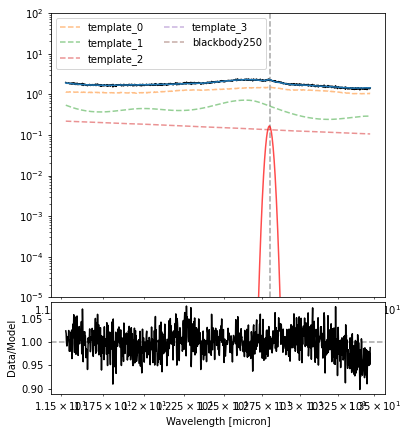

FITSPEC: Line fit took 1.0 s.
FITLOOP: Second call to FITSPEC
1.0
1
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.3115e+02                                    4.05e+00    
       1              2         5.3106e+02      8.68e-02       9.59e+00       1.31e+00    
       2              3         5.3105e+02      4.05e-03       1.99e+00       2.66e-01    
       3              4         5.3105e+02      5.09e-04       1.05e+00       1.41e-01    
       4              5         5.3105e+02      6.30e-05       2.96e-01       3.98e-02    
       5              6         5.3105e+02      7.83e-06       1.21e-01       1.63e-02    
       6              7         5.3105e+02      9.73e-07       3.90e-02       5.26e-03    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 5.3115e+02, final cost 5.3105e+02, first-order optimality 5.26e-03.
[[Model]]
    Model(m

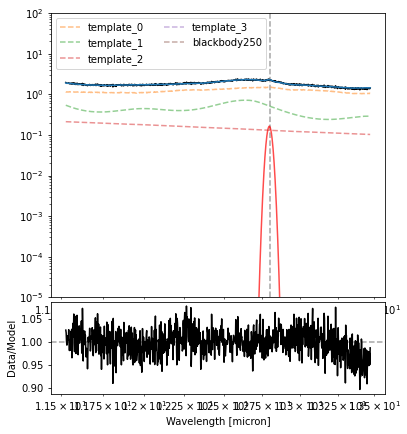

FITSPEC: Line fit took 0.9 s.


In [14]:
q3df(initproc, cols=cols, rows=rows, quiet=False)

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

Line(s)      name   
-----------
[NeII]12.81  outside of Morton validity for conversion to air
CUBE: WMAP extension does not exist.
Column 7 of 16
    Row 14 of 25


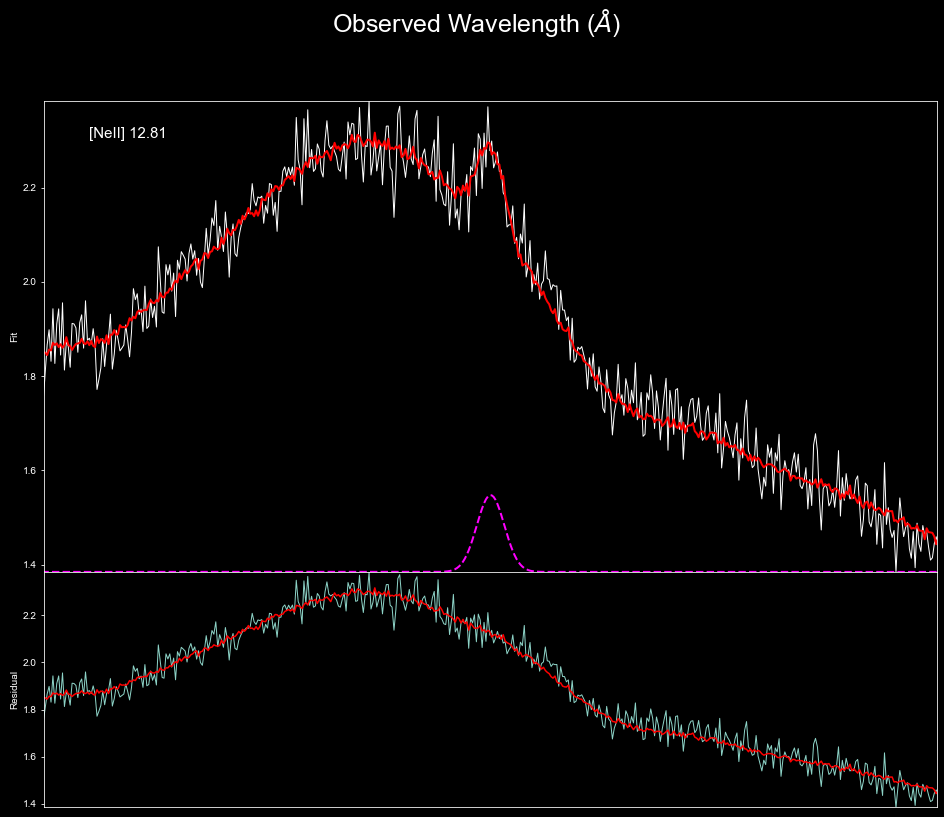

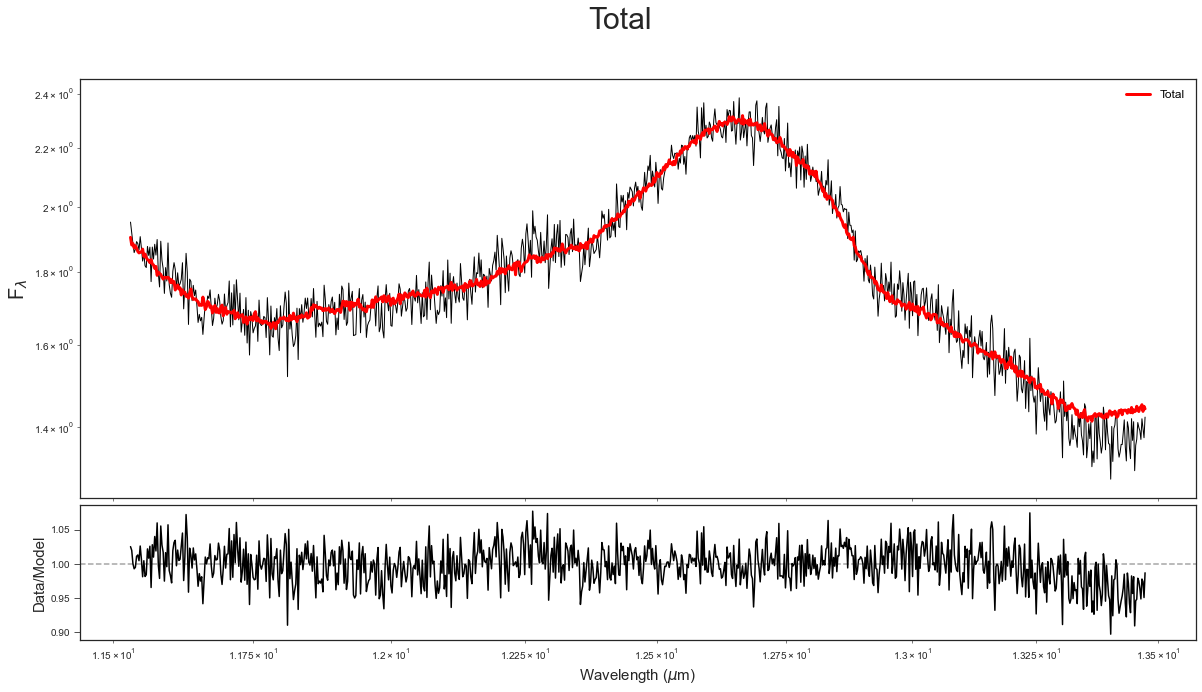

In [15]:
%matplotlib inline
q3da(initproc, cols=cols, rows=rows, quiet=False)